This note book is based on 2.training.your.first.neural.network.ipynb from https://github.com/PacktPublishing/Deep-learning-with-PyTorch-video by Anand Saha. 

Utillity function that has been adapted for Google Colab

### 2. Building a simple neural network

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.autograd import Variable

# Custom DataSet
import numpy as np
import pandas as pd
from torch.utils.data.dataset import Dataset


In [2]:


label_idx = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}


class IrisDataset(Dataset):

    def __init__(self, data):
        self.data = data
           
    def __getitem__(self, index):
        item = self.data.iloc[index].values
        return (item[0:4].astype(np.float32), item[4].astype(np.int))

    def __len__(self):
        return self.data.shape[0]


def get_datasets(iris_file, train_ratio=0.80):

    labels = {'class': label_idx}
    data = pd.read_csv(iris_file)
    data.replace(labels, inplace=True)

    train_df = data.sample(frac=train_ratio, random_state=3)
    test_df = data.loc[~data.index.isin(train_df.index), :]

    return IrisDataset(train_df), IrisDataset(test_df)

### The Dataset and the challenge

![iris](data/iris.jpg)

The **Iris** flower, image source: [Wikimedia](https://en.wikipedia.org/wiki/Iris_(plant))


| sepal_length_cm | sepal_width_cm | petal_length_cm | petal_width_cm | class           |
|-----------------|----------------|-----------------|----------------|-----------------|
| 5.1             | 3.5            | 1.4             | 0.2            | Iris-setosa     |
| 7.0             | 3.2            | 4.7             | 1.4            | Iris-versicolor |
| 6.3             | 3.3            | 6.0             | 2.5            | Iris-virginica  |


* Total instances: 150 (we have separated 20% into validation set, rest into training set)
* Download: [Data Source](https://archive.ics.uci.edu/ml/datasets/iris)

### Create the Fully Connected Feed Forward Neural Network

**Create the module**

In [4]:
class IrisNet(nn.Module):
    
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

**Print the module**

In [5]:
model = IrisNet(4, 100, 50, 3)
print(model)

IrisNet(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=50, out_features=3, bias=True)
)


### Create the DataLoader

In [6]:
batch_size = 60
iris_data_file = 'https://raw.githubusercontent.com/PacktPublishing/Deep-learning-with-PyTorch-video/master/data/iris.data.txt'

In [7]:
# Get the datasets
train_ds, test_ds = get_datasets(iris_data_file)

# How many instances have we got?
print('# instances in training set: ', len(train_ds))
print('# instances in testing/validation set: ', len(test_ds))

# Create the dataloaders - for training and validation/testing
# We will be using the term validation and testing data interchangably
train_loader = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=True)

# instances in training set:  120
# instances in testing/validation set:  30


### Instantiate the network, the loss function and the optimizer

In [8]:
# Our model
net = IrisNet(4, 100, 50, 3)

# Out loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, nesterov=True, momentum=0.9, dampening=0)  

### Train it!

In [9]:
num_epochs = 500

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    
    train_correct = 0
    train_total = 0
    
    for i, (items, classes) in enumerate(train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        net.train()           # Put the network into training mode
        
        optimizer.zero_grad() # Clear off the gradients from any past operation
        outputs = net(items)  # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        loss.backward()       # Calculate the gradients with help of back propagation
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data
        train_total += classes.size(0)    
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == classes.data).sum()

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, i+1, len(train_ds)//batch_size, loss.item()))

    net.eval()                 # Put the network into evaluation mode
    
    # Book keeping
    # Record the loss
    train_loss.append(loss.item())

    # What was our train accuracy?
    train_accuracy.append((100 * train_correct / train_total))
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    test_items = torch.FloatTensor(test_ds.data.values[:, 0:4])
    test_classes = torch.LongTensor(test_ds.data.values[:, 4])

    outputs = net(Variable(test_items))
    loss = criterion(outputs, Variable(test_classes))
    test_loss.append(loss.item())
    _, predicted = torch.max(outputs.data, 1)
    total = test_classes.size(0)
    correct = (predicted == test_classes).sum()
    test_accuracy.append((100 * correct / total))

Epoch 1/500, Iteration 1/2, Loss: 1.1826
Epoch 1/500, Iteration 2/2, Loss: 1.1756
Epoch 2/500, Iteration 1/2, Loss: 1.1116
Epoch 2/500, Iteration 2/2, Loss: 1.1924
Epoch 3/500, Iteration 1/2, Loss: 1.1276
Epoch 3/500, Iteration 2/2, Loss: 1.1133
Epoch 4/500, Iteration 1/2, Loss: 1.1206
Epoch 4/500, Iteration 2/2, Loss: 1.0577
Epoch 5/500, Iteration 1/2, Loss: 1.0553
Epoch 5/500, Iteration 2/2, Loss: 1.0512
Epoch 6/500, Iteration 1/2, Loss: 1.0374
Epoch 6/500, Iteration 2/2, Loss: 1.0174
Epoch 7/500, Iteration 1/2, Loss: 1.0039
Epoch 7/500, Iteration 2/2, Loss: 1.0010
Epoch 8/500, Iteration 1/2, Loss: 0.9918
Epoch 8/500, Iteration 2/2, Loss: 0.9852
Epoch 9/500, Iteration 1/2, Loss: 0.9851
Epoch 9/500, Iteration 2/2, Loss: 0.9645
Epoch 10/500, Iteration 1/2, Loss: 0.9472
Epoch 10/500, Iteration 2/2, Loss: 0.9827
Epoch 11/500, Iteration 1/2, Loss: 0.9573
Epoch 11/500, Iteration 2/2, Loss: 0.9467
Epoch 12/500, Iteration 1/2, Loss: 0.9854
Epoch 12/500, Iteration 2/2, Loss: 0.8956
Epoch 13/5

Epoch 100/500, Iteration 1/2, Loss: 0.4247
Epoch 100/500, Iteration 2/2, Loss: 0.3351
Epoch 101/500, Iteration 1/2, Loss: 0.3920
Epoch 101/500, Iteration 2/2, Loss: 0.3637
Epoch 102/500, Iteration 1/2, Loss: 0.3654
Epoch 102/500, Iteration 2/2, Loss: 0.3859
Epoch 103/500, Iteration 1/2, Loss: 0.3862
Epoch 103/500, Iteration 2/2, Loss: 0.3633
Epoch 104/500, Iteration 1/2, Loss: 0.3655
Epoch 104/500, Iteration 2/2, Loss: 0.3782
Epoch 105/500, Iteration 1/2, Loss: 0.3879
Epoch 105/500, Iteration 2/2, Loss: 0.3508
Epoch 106/500, Iteration 1/2, Loss: 0.3566
Epoch 106/500, Iteration 2/2, Loss: 0.3778
Epoch 107/500, Iteration 1/2, Loss: 0.3494
Epoch 107/500, Iteration 2/2, Loss: 0.3813
Epoch 108/500, Iteration 1/2, Loss: 0.3511
Epoch 108/500, Iteration 2/2, Loss: 0.3753
Epoch 109/500, Iteration 1/2, Loss: 0.3582
Epoch 109/500, Iteration 2/2, Loss: 0.3641
Epoch 110/500, Iteration 1/2, Loss: 0.3599
Epoch 110/500, Iteration 2/2, Loss: 0.3584
Epoch 111/500, Iteration 1/2, Loss: 0.3331
Epoch 111/5

Epoch 202/500, Iteration 2/2, Loss: 0.2150
Epoch 203/500, Iteration 1/2, Loss: 0.2325
Epoch 203/500, Iteration 2/2, Loss: 0.1800
Epoch 204/500, Iteration 1/2, Loss: 0.2178
Epoch 204/500, Iteration 2/2, Loss: 0.1915
Epoch 205/500, Iteration 1/2, Loss: 0.1956
Epoch 205/500, Iteration 2/2, Loss: 0.2113
Epoch 206/500, Iteration 1/2, Loss: 0.2248
Epoch 206/500, Iteration 2/2, Loss: 0.1798
Epoch 207/500, Iteration 1/2, Loss: 0.2275
Epoch 207/500, Iteration 2/2, Loss: 0.1766
Epoch 208/500, Iteration 1/2, Loss: 0.2013
Epoch 208/500, Iteration 2/2, Loss: 0.2005
Epoch 209/500, Iteration 1/2, Loss: 0.1994
Epoch 209/500, Iteration 2/2, Loss: 0.1990
Epoch 210/500, Iteration 1/2, Loss: 0.1950
Epoch 210/500, Iteration 2/2, Loss: 0.2031
Epoch 211/500, Iteration 1/2, Loss: 0.1962
Epoch 211/500, Iteration 2/2, Loss: 0.1988
Epoch 212/500, Iteration 1/2, Loss: 0.2060
Epoch 212/500, Iteration 2/2, Loss: 0.1868
Epoch 213/500, Iteration 1/2, Loss: 0.2035
Epoch 213/500, Iteration 2/2, Loss: 0.1868
Epoch 214/5

Epoch 304/500, Iteration 1/2, Loss: 0.1347
Epoch 304/500, Iteration 2/2, Loss: 0.1365
Epoch 305/500, Iteration 1/2, Loss: 0.0969
Epoch 305/500, Iteration 2/2, Loss: 0.1732
Epoch 306/500, Iteration 1/2, Loss: 0.1138
Epoch 306/500, Iteration 2/2, Loss: 0.1552
Epoch 307/500, Iteration 1/2, Loss: 0.1135
Epoch 307/500, Iteration 2/2, Loss: 0.1552
Epoch 308/500, Iteration 1/2, Loss: 0.1430
Epoch 308/500, Iteration 2/2, Loss: 0.1250
Epoch 309/500, Iteration 1/2, Loss: 0.1123
Epoch 309/500, Iteration 2/2, Loss: 0.1552
Epoch 310/500, Iteration 1/2, Loss: 0.1306
Epoch 310/500, Iteration 2/2, Loss: 0.1356
Epoch 311/500, Iteration 1/2, Loss: 0.1541
Epoch 311/500, Iteration 2/2, Loss: 0.1111
Epoch 312/500, Iteration 1/2, Loss: 0.1157
Epoch 312/500, Iteration 2/2, Loss: 0.1486
Epoch 313/500, Iteration 1/2, Loss: 0.1090
Epoch 313/500, Iteration 2/2, Loss: 0.1546
Epoch 314/500, Iteration 1/2, Loss: 0.1469
Epoch 314/500, Iteration 2/2, Loss: 0.1173
Epoch 315/500, Iteration 1/2, Loss: 0.1503
Epoch 315/5

Epoch 402/500, Iteration 1/2, Loss: 0.0887
Epoch 402/500, Iteration 2/2, Loss: 0.1235
Epoch 403/500, Iteration 1/2, Loss: 0.1254
Epoch 403/500, Iteration 2/2, Loss: 0.0882
Epoch 404/500, Iteration 1/2, Loss: 0.0783
Epoch 404/500, Iteration 2/2, Loss: 0.1330
Epoch 405/500, Iteration 1/2, Loss: 0.1019
Epoch 405/500, Iteration 2/2, Loss: 0.1091
Epoch 406/500, Iteration 1/2, Loss: 0.0989
Epoch 406/500, Iteration 2/2, Loss: 0.1116
Epoch 407/500, Iteration 1/2, Loss: 0.1168
Epoch 407/500, Iteration 2/2, Loss: 0.0934
Epoch 408/500, Iteration 1/2, Loss: 0.0842
Epoch 408/500, Iteration 2/2, Loss: 0.1255
Epoch 409/500, Iteration 1/2, Loss: 0.1013
Epoch 409/500, Iteration 2/2, Loss: 0.1079
Epoch 410/500, Iteration 1/2, Loss: 0.1140
Epoch 410/500, Iteration 2/2, Loss: 0.0957
Epoch 411/500, Iteration 1/2, Loss: 0.1382
Epoch 411/500, Iteration 2/2, Loss: 0.0723
Epoch 412/500, Iteration 1/2, Loss: 0.0797
Epoch 412/500, Iteration 2/2, Loss: 0.1284
Epoch 413/500, Iteration 1/2, Loss: 0.0758
Epoch 413/5

Plot loss vs iterations

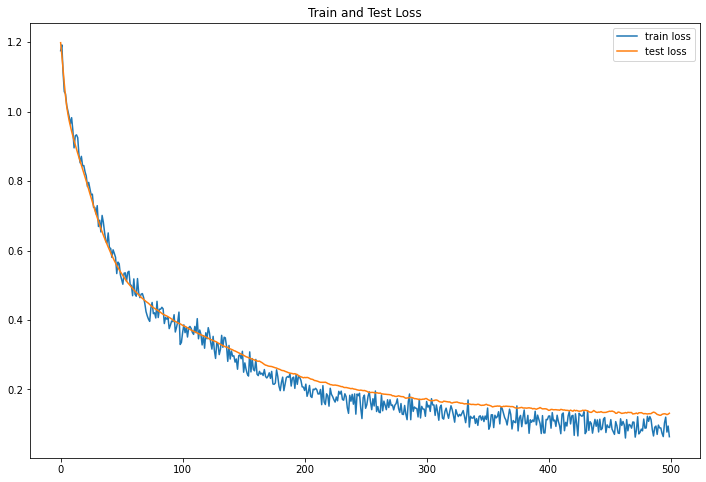

In [10]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.title("Train and Test Loss")
plt.legend()
plt.show()

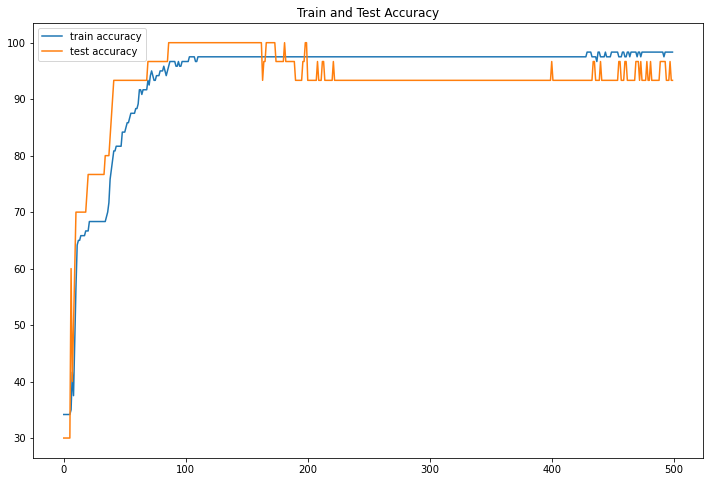

In [11]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_accuracy, label='train accuracy')
plt.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
plt.legend()
plt.show()

In [41]:
output = net(Variable(torch.FloatTensor([[5.1, 3.5, 1.4, 0.2]])))

In [42]:
output

tensor([[ 10.5498,   5.0323, -13.5322]], grad_fn=<AddmmBackward>)

In [43]:
_, predicted_class = torch.max(output.data, 1)
print('Predicted class: ', predicted_class.numpy()[0])
print('Expected class: ', 0 )

Predicted class:  0
Expected class:  0


In [44]:
torch.max(output.data, 1)

torch.return_types.max(
values=tensor([10.5498]),
indices=tensor([0]))

In [45]:
predicted_class.numpy()

array([0])